<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [4]:
df.sort_index(inplace=True)

In [5]:
df = df.resample('1H').sum()

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные подготовлены.

## Анализ

Выполним анализ временного ряда, для начала добавим новые признаки основанные на временном ряде:

In [9]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

Полный график временного ряда:

<AxesSubplot:xlabel='datetime'>

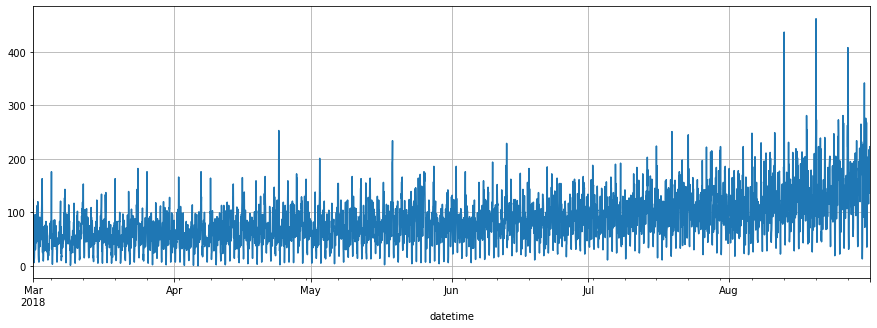

In [10]:
df['num_orders'].plot(figsize=[15,5], grid=True)

Средний месячный график:

<AxesSubplot:xlabel='month'>

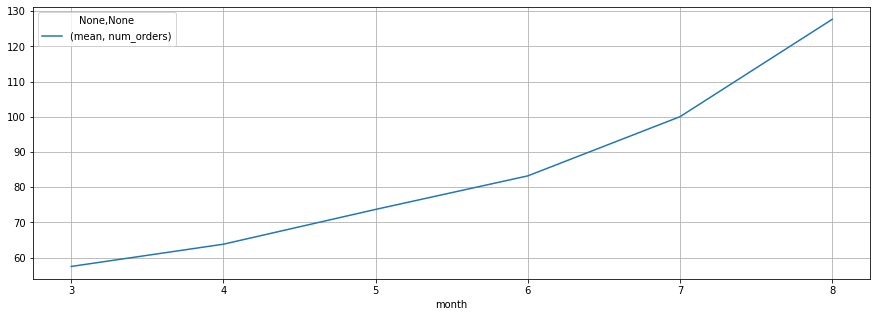

In [11]:
df.pivot_table(index = 'month', values='num_orders', aggfunc=['mean']).plot(figsize=[15,5] ,grid=True)

На месячном графике виден растущий тренд, среднее число заказов такси растет от марта к августу, возможно это связано с летними месяцами и сезонами отпусков.

Средний недельный график:

<AxesSubplot:xlabel='dayofweek'>

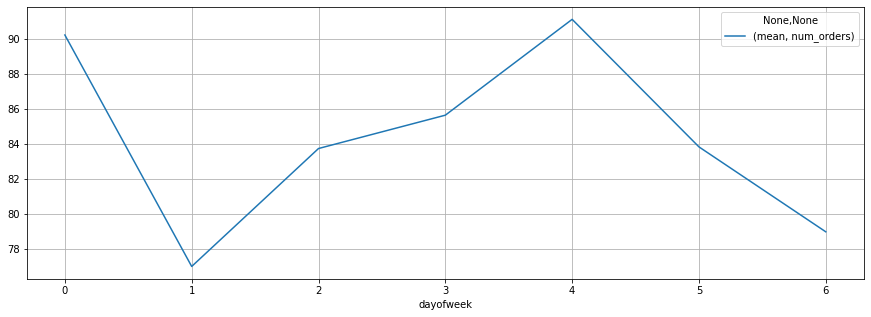

In [12]:
df.pivot_table(index = 'dayofweek', values='num_orders', aggfunc=['mean']).plot(figsize=[15,5] ,grid=True)

На недельном графике можно увидеть недельную закономерность: максимальное количество вызовов такси фиксируется в понедельник и пятницу (начало и конец рабочей недели).

Средний дневной график:

<AxesSubplot:xlabel='day'>

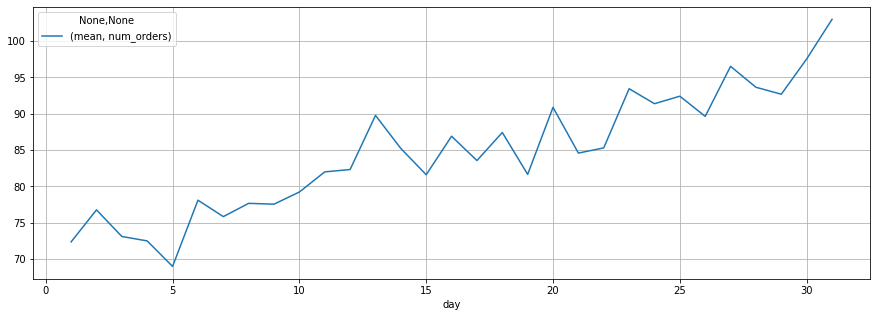

In [13]:
df.pivot_table(index = 'day', values='num_orders', aggfunc=['mean']).plot(figsize=[15,5] ,grid=True)

Из графика виден тренд на повышение заказов с течением времени, что аналогично показывает среднемесячный график - растущий тренд.

Средний часовой график:

<AxesSubplot:xlabel='hour'>

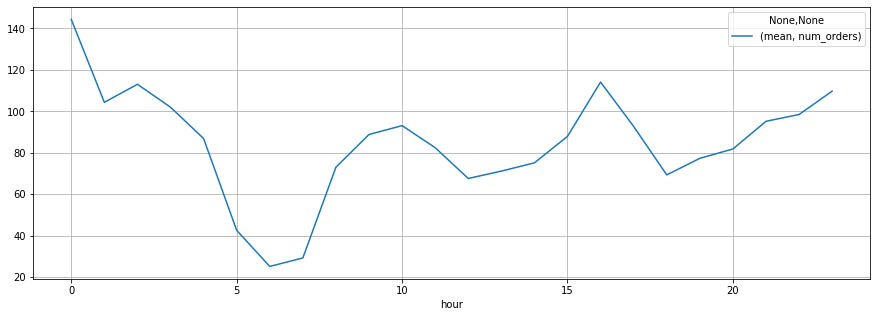

In [14]:
df.pivot_table(index = 'hour', values='num_orders', aggfunc=['mean']).plot(figsize=[15,5] ,grid=True)

Из часового графика видна определенная закономерность, минимум заказов такси осуществляется приблезительно в 5 часов ночи, а далее число заказов начинает расти и достигает максимума в полночь.

Теперь разложим временной ряд на компоненты:

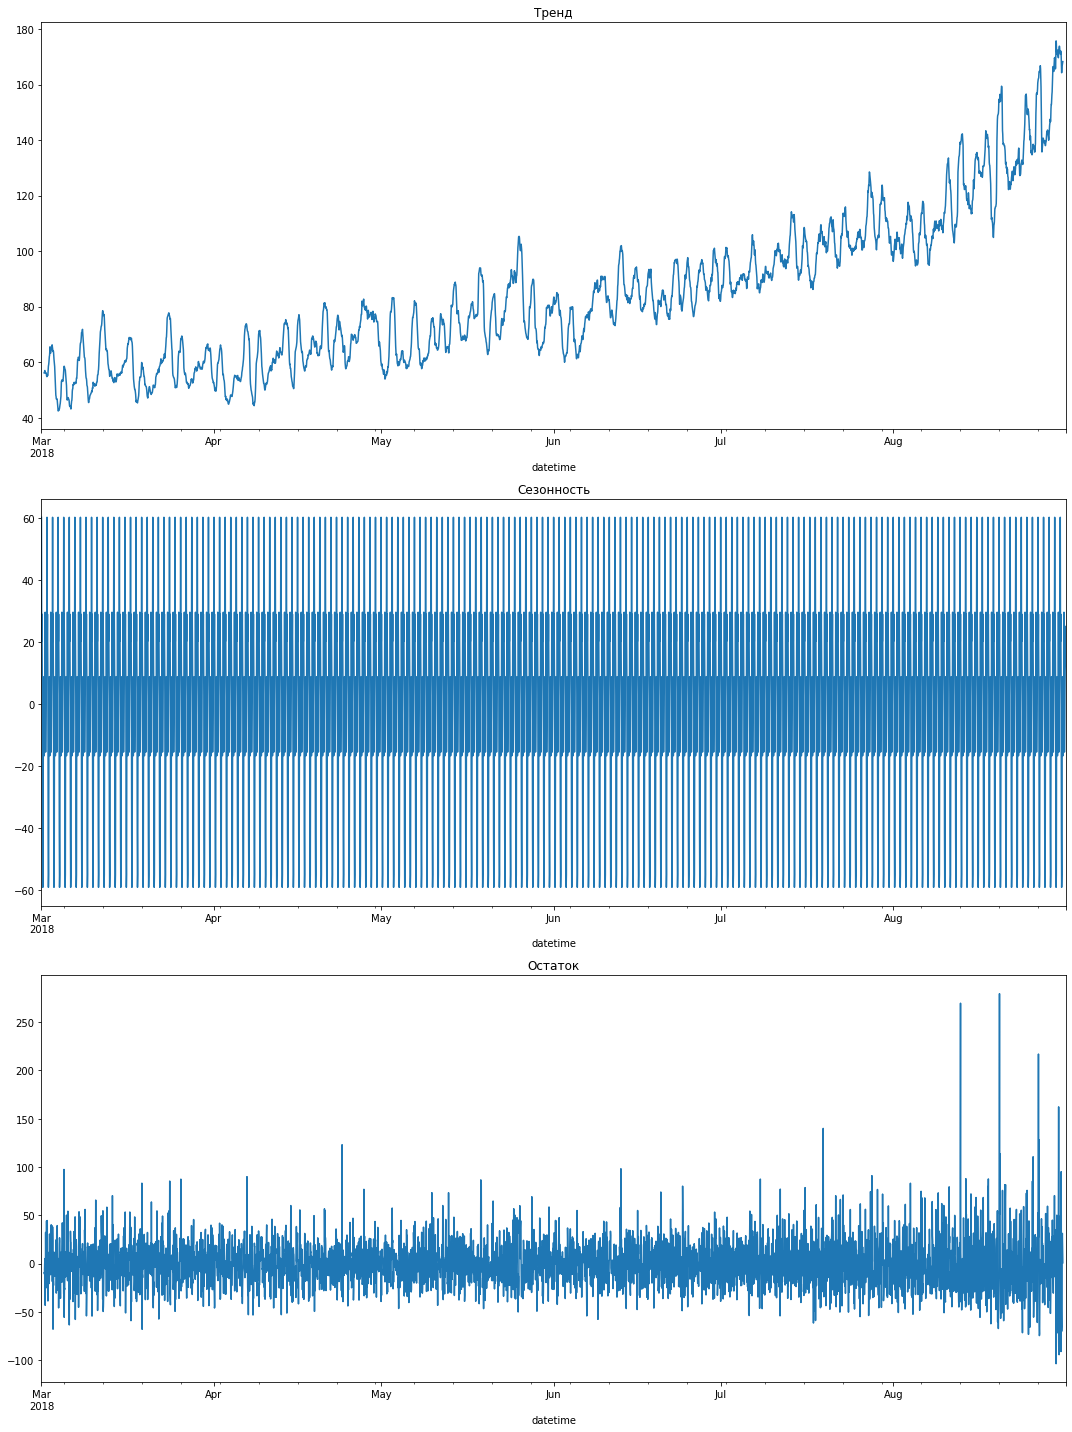

In [15]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

Вывод: во временном ряде существует растущий тренд, а также существует несколько сезонностей: первая - в течении недели максимальное число заказов такси наблюдается в понедельник, во вторник наблюдается минимум заказов с последующим ростом к пятнице, в выходные опять спад заказов, с последующим максимумом в понедельник; вторая - в течении дня минимум заказов происходит в 5 утра, далее число плавно растет и достигает максимума к полночи, после чего идет спад заказов до 5 утра.

## Обучение

### Линейная регрессия

In [16]:
df = df.drop(['day', 'month'], axis=1)

Ранее добавленные признаки "День" и "Месяц" удалим как не отражающие сезонность.

In [17]:
df.head()

,num_orders,hour,dayofweek
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3


In [18]:
def make_features(df, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(df, 24, 120)

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [21]:
train_features = train.drop(['num_orders'], axis=True)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=True)
test_target = test['num_orders']

In [22]:
model = LinearRegression()
model.fit(train_features, train_target)
predict_train = model.predict(train_features)
predict_test = model.predict(test_features)

In [23]:
print("RMSE обучающей выборки:", mean_squared_error(predict_train, train_target)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(predict_test, test_target)**0.5)

RMSE обучающей выборки: 25.77804648216871
RMSE тестовой выборки:  44.74884002226531


### Catboost

In [24]:
cat_features = ['hour', 'dayofweek']

Найдем оптимальные гиперпараметры:

In [ ]:
model = CatBoostRegressor()
params = {
    'max_depth' : [2, 5, 10],
    'random_seed' : [12345],
    'learning_rate' : [0.1],
    'logging_level' : ['Silent'],
    'eval_metric' : ['RMSE']
}
grid = GridSearchCV(estimator=model,
                    param_grid=params, 
                               cv=TimeSeriesSplit(n_splits=5),
                               scoring='neg_mean_squared_error')
grid.fit(train_features, train_target,
         cat_features=cat_features,
         plot=False)

In [ ]:
print('Лучшие гиперпараметры: ', grid.best_params_)

In [ ]:
print('RMSE: {:.2f}'.format((-grid.best_score_)**0.5))

Обучим модель с оптимальными гиперпараметрами:

In [ ]:
model = CatBoostRegressor(max_depth = 5,
                          random_seed=12345,
                          learning_rate=0.1,
                          logging_level='Silent')
model.fit(train_features,
          train_target,
          cat_features=cat_features,
          plot=False)
pred_test = model.predict(test_features)

In [ ]:
catboost_rmse = (mean_squared_error(pred_test, test_target))**0.5
catboost_rmse

In [ ]:
a=np.array(test_target, np.int32)
b=np.array(pred_test, np.int32)

plt.plot(a, color = 'red', label = 'Historical data')
plt.plot(b, color = 'blue', label='Predicted data')
plt.legend()
plt.show()

Вывод: лучший результат показала модель Catboost с результатом RMSE = 40,37 тестовой выборке.